In [1]:
import os
import pandas as pd
import random

import sys
sys.path.insert(0, '..')

from unpast.run_unpast import unpast
from unpast.utils.method import prepare_input_matrix
from unpast.utils.consensus import make_consensus_biclusters

### Input and output

This example uses expressions of 200 randomly chosen samples from the TCGA-BRCA dataset (normalized and standardized log2(x+1) RNA-seq counts)

In [2]:
# input .tsv file; features in rows, samples in columns
exprs_file = "test_data_TCGA200/TCGA_200.exprs_z.tsv" 

if not os.path.exists(exprs_file):
    from gdown import download
    from zipfile import ZipFile

    url = 'https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN'
    output = 'TCGA200_example.zip'
    download(url, output, quiet=False)

    with ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()

    os.remove(output)

# or download and unzip it manually: https://drive.google.com/file/d/1zee_GssqXCv_-tokLRJKR8cLksxsa8UN/view?usp=drive_link# input .tsv file; features in rows, samples in columns

Downloading...
From (original): https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN
From (redirected): https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN&confirm=t&uuid=951bdf4f-62a4-4651-a7d2-9f1dbd50c7c4
To: /home/olga/UHH/UnPaSt/unpast/notebooks/TCGA200_example.zip
100%|██████████| 26.8M/26.8M [00:01<00:00, 21.7MB/s]


In [3]:
# specify output folder and output file prefix
basename = 'TCGA200'
out_dir = "TCGA200_example/"

### Run UnPaSt 

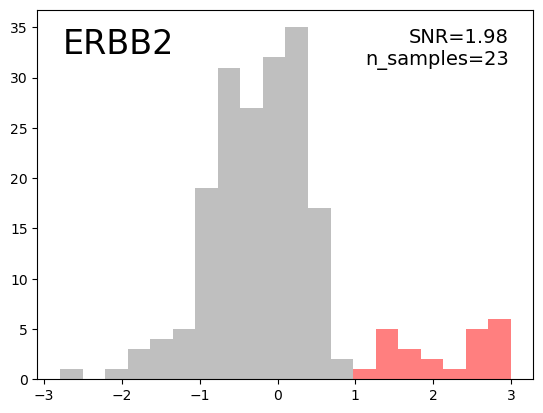

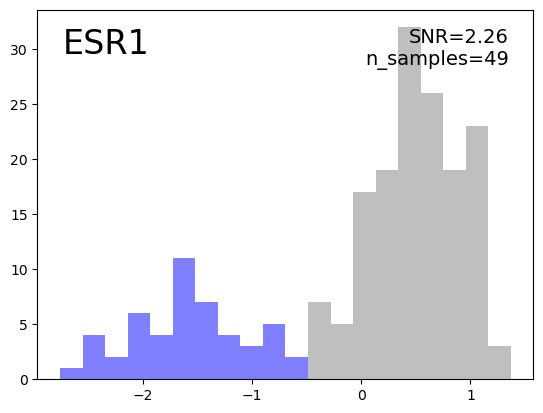

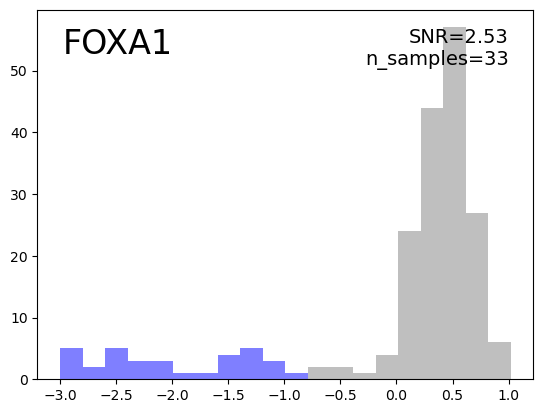

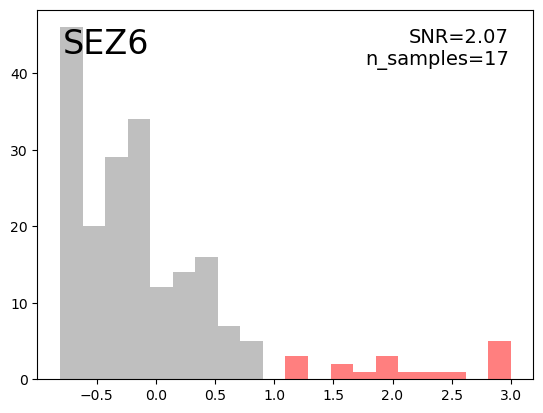

In [4]:
results = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            # optional: show distributions of some selected features
            # known subtype-specific biomarkers are chosen in this example
            show_fits = ["ERBB2","ESR1","FOXA1","SEZ6"],
            seed = 42
            )

In [5]:
results.head(2)

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
0,3.528302,39,37,"{SLC7A8, ANKRD30A, EFCC1, ADGRV1, GATA3, MYB, ...","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...",DOWN,{},"{SLC7A8, ANKRD30A, EFCC1, GATA3, ADGRV1, MYB, ...","{1923, 388, 9990, 3847, 7176, 11795, 11159, 38...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."
1,2.453225,157,38,"{ZIC1, PRR18, ARSF, ART3, SMC1B, MIA, MID1, RO...","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...",UP,"{ZIC1, PRR18, ARSF, ART3, SMC1B, MIA, MID1, RO...",{},"{7681, 9729, 12290, 3077, 1035, 7695, 1553, 20...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."


### Re-run UnPaSt using previously computed binarization results

add `load = True`

In [6]:
results2 = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            load= True, # try loading precomputed binarization results
            seed = 42
            )

### Read and write UnPaSt results

In [7]:
from unpast.utils.io import write_bic_table, read_bic_table

In [8]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True"
seed = 42
bic_file = out_dir + "/"+basename+".seed="+str(seed)+suffix+".biclusters.tsv"
biclusters = read_bic_table(bic_file)
biclusters.head(2)

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
id,,,,,,,,,,
0,3.528302,39,37,"{SLC7A8, ANKRD30A, EFCC1, ADGRV1, GATA3, MYB, ...","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...",DOWN,{},"{SLC7A8, ANKRD30A, EFCC1, ADGRV1, GATA3, MYB, ...","{1923, 388, 9990, 3847, 7176, 11795, 11159, 38...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."
1,2.453225,157,38,"{ZIC1, PRR18, ARSF, ART3, SMC1B, MIA, MID1, RO...","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...",UP,"{ZIC1, PRR18, ARSF, ART3, SMC1B, MIA, MID1, RO...",{},"{7681, 12290, 9729, 3077, 1035, 7695, 1553, 20...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."


In [9]:
new_file_name = "TCGA200_example/TCGA200.biclusters.tsv"
write_bic_table(biclusters,new_file_name)

### Consensus biclusters from 5 runs

#### 1. Running UnPaSt five times with different seeds

* biclusters from individual runs:

\<basename>.seed=\<seed>.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [10]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [11]:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                  out_dir=out_dir,
                  load=False,
                  seed = seed
                 )
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 117
seed = 403958	n_biclusters: 146
seed = 794772	n_biclusters: 135
seed = 933488	n_biclusters: 118
seed = 441001	n_biclusters: 124


#### 2. Combine the results of five independent runs to consensus biclusters

* consensus biclusters:

TCGA200.consensus_seed=0.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [12]:
exprs = pd.read_csv(exprs_file,sep="\t",index_col = 0)

# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
consensus_biclusters = make_consensus_biclusters(biclusters, exprs_z, 
                                                seed = analysis_seed,
                                                verbose = True,
                                                plot = False
                                                )

consensus_biclusters.head(3)

10 s for similarity matrix
	Running Louvain ...
		modularity: newman


sknetwork version used: 0.33.0


	curve type: increasing
	Louvain runtime: modules detected in 0.33 s.
	modules: 141, not clustered features 74 
		similarity cutoff: 0.43 modularity: 0.991
keep genes included in at least 2 merged biclusters
all consensus biclusters: 220
detected 2+ times:136
2 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,2.922866,155,36,"{ZIC1, PRR18, ART3, SMC1B, PADI2, C1orf64, INA...","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...","{ZIC1, PRR18, ART3, SMC1B, PADI2, INA, FZD9, R...","{GATA3, MYB, FOXA1, FBP1, CYP4Z2P, MSX2, AGR2,...","{9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...",BOTH,7,"{seed=403958_0, seed=794772_1, seed=441001_2, ..."
1,2.763514,2,14,"{LUC7L2, ISY1-RAB43}","{TCGA-GM-A2DA-01, TCGA-E2-A1LS-01, TCGA-E9-A54...",{},"{LUC7L2, ISY1-RAB43}","{6282, 7263}","{193, 69, 70, 166, 168, 110, 19, 52, 179, 86, ...",DOWN,2,"{seed=885440_26, seed=933488_1}"
2,2.674523,7,24,"{TLX3, EN1, PAPL, IGSF23, NCAN, DMRT1, KRT9}","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...","{TLX3, EN1, PAPL, IGSF23, NCAN, DMRT1, KRT9}",{},"{6080, 8261, 12997, 6792, 4019, 9012, 3546}","{131, 7, 139, 12, 13, 145, 19, 147, 157, 36, 1...",UP,7,"{seed=794772_7, seed=794772_4, seed=885440_6, ..."


# Example biclusters 

In [13]:
g = "ERBB2"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
34,1.708024,15,20,"{AMIGO3, SERHL2, STARD3, UGT2B10, ADAM2, ERBB2...","{TCGA-B6-A0RH-01, TCGA-A8-A0A7-01, TCGA-AN-A0F...","{AMIGO3, NEU4, UGT2B10, ADAM2, ERBB2, SOHLH1, ...",{},"{3552, 14946, 11338, 12074, 12875, 9294, 12367...","{129, 132, 134, 149, 28, 29, 39, 46, 47, 54, 6...",UP,5,"{seed=403958_16, seed=441001_38, seed=933488_1..."


In [14]:
g = "ESR1"
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
3,2.472176,139,47,"{NEURL1, SLC7A8, ANKRD30A, FOXJ1, ANXA9, EFCC1...","{TCGA-E9-A244-01, TCGA-A8-A0A7-01, TCGA-D8-A1J...",{},"{NEURL1, SLC7A8, ANKRD30A, FOXJ1, ANXA9, EFCC1...","{3596, 1529, 5647, 13331, 20, 4117, 1558, 1179...","{128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...",DOWN,5,"{seed=885440_1, seed=794772_3, seed=933488_2, ..."


In [15]:
g = "FOXA1"
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,2.922866,155,36,"{ZIC1, PRR18, ART3, SMC1B, PADI2, C1orf64, INA...","{TCGA-E9-A244-01, TCGA-C8-A134-01, TCGA-D8-A14...","{ZIC1, PRR18, ART3, SMC1B, PADI2, INA, FZD9, R...","{GATA3, MYB, FOXA1, FBP1, CYP4Z2P, MSX2, AGR2,...","{9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...",BOTH,7,"{seed=403958_0, seed=794772_1, seed=441001_2, ..."
3,2.472176,139,47,"{NEURL1, SLC7A8, ANKRD30A, FOXJ1, ANXA9, EFCC1...","{TCGA-E9-A244-01, TCGA-A8-A0A7-01, TCGA-D8-A1J...",{},"{NEURL1, SLC7A8, ANKRD30A, FOXJ1, ANXA9, EFCC1...","{3596, 1529, 5647, 13331, 20, 4117, 1558, 1179...","{128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...",DOWN,5,"{seed=885440_1, seed=794772_3, seed=933488_2, ..."


In [16]:
g = "SEZ6"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
28,1.734242,10,17,"{SEZ6, CARTPT, PCSK2, SYT4, AMER3, KCNH6, LRTM...","{TCGA-E9-A3HO-01, TCGA-E2-A15S-01, TCGA-C8-A1H...","{SEZ6, PCSK2, CARTPT, SYT4, AMER3, KCNH6, LRTM...",{},"{11392, 2913, 12579, 6442, 12523, 1875, 9140, ...","{33, 98, 35, 162, 134, 103, 168, 77, 17, 177, ...",UP,5,"{seed=933488_13, seed=885440_9, seed=403958_8,..."
29,1.732302,3,25,"{AMER3, SEZ6, KCNH6}","{TCGA-A8-A083-01, TCGA-AR-A0U3-01, TCGA-E2-A56...","{AMER3, SEZ6, KCNH6}",{},"{11392, 6442, 534}","{1, 130, 17, 20, 21, 150, 23, 151, 31, 33, 162...",UP,3,"{seed=885440_87, seed=794772_68, seed=403958_24}"


### Plot heatmap for selected biclusters
* Basal: 0,lightblue
* Her2+: 34,yellow
* Neuroendocrine: 28,orange

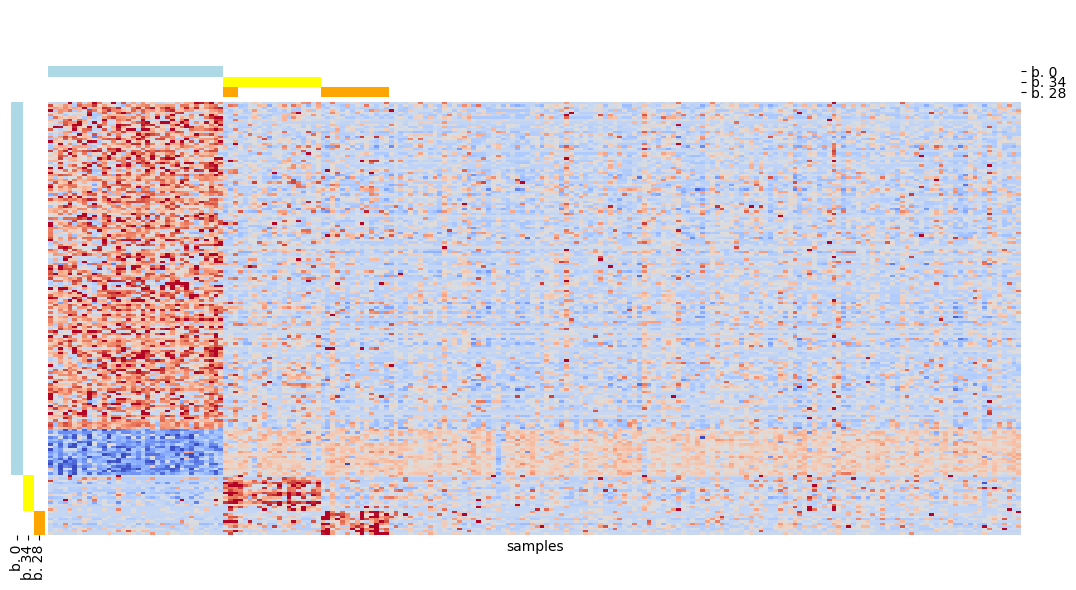

In [17]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import zscore

# select several biclusters to plot
# Basal: 0,lightblue; Her2+: 34,yellow; Neuroendocrine: 28,orange
i = [0,34,28] 
b = consensus_biclusters.loc[i,:]


tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors=["lightblue","yellow","orange"], # "auto",
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = False,
                no_row_colors = False,cluster_rows=False
             )